# Neural network for segmenting LV of heart

## Introduction
This work was performed as part of the MRAI workshop (MIDL 2019 satellite meeting) with exercises designed by Esther Puyol (https://github.com/estherpuyol/MRAI_workshop).

### Objective
Train a simple neural network to automatically segment the Left ventricle from 2D short axis cardiac MR images.

## Import modules
The network is built using functions and classes from the [pytorch library](https://pytorch.org/docs/stable/index.html) 

In [0]:
import os
import numpy as np
import pylab as plt
import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit

## Download dataset
The data for this study is from the [Sunnybrook Cardiac Data](https://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/)

A preprocessed subset of this data is used, where the data is filtered to contain only left ventricle myocardium segmentations and reduced in XY dimensions.

In [2]:
![ -f scd_lvsegs.npz ] || wget https://github.com/estherpuyol/MRAI_workshop/raw/master/scd_lvsegs.npz

data = np.load('scd_lvsegs.npz') # load all the data from the archive

images = data['images'] # images in BHW array order : .shape (420, 64, 64)]
segs = data['segs'] # segmentations in BHW array order : .shape (420, 64, 64)
caseIndices = data['caseIndices'] # the indices in `images` for each case : .shape (45, 2)

images = images.astype(np.float32)/images.max() # normalize images

--2019-08-16 13:52:23--  https://github.com/estherpuyol/MRAI_workshop/raw/master/scd_lvsegs.npz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/estherpuyol/MRAI_workshop/master/scd_lvsegs.npz [following]
--2019-08-16 13:52:24--  https://raw.githubusercontent.com/estherpuyol/MRAI_workshop/master/scd_lvsegs.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2133403 (2.0M) [application/octet-stream]
Saving to: ‘scd_lvsegs.npz’

scd_lvsegs.npz      100%[===================>]   2.03M  --.-KB/s    in 0.09s   

2019-08-16 13:52:26 (22.4 MB/s) - ‘scd_lvsegs.npz’ saved [2133403/2133403]



## Split training and test data
This code block splits the data set into training and test data where the variable n_training determines the number of test cases.  

In [0]:
n_training = 6

testIndex = caseIndices[-n_training,0] # keep the last n_training cases for testing

# divide the images, segmentations, and categories into train/test sets
trainImages,trainSegs = images[:testIndex],segs[:testIndex]
testImages,testSegs = images[testIndex:],segs[testIndex:]


## Define segmentation network
I have chosen to implement a Unet style network for this classification problem. These networks perform well in these cases since they learn both high and low level features 


In [0]:
class Unet(tf.keras.Model):
    def __init__(self, input_shape, conv_channels, kernels=[3], strides=[2], training=True):
        super().__init__()

        self._conv_channels = conv_channels
        self._kernels = kernels
        self._strides = strides

        # check kernel, strides and substack size are equal and make them equal if only a single kernel size is used
        if (len(conv_channels) is not len(kernels)):
            if len(kernels) is 1:
                self._kernels = [item for item in self._kernels for i in range(len(self._conv_channels))]
            else:
                raise AssertionError('conv_channels and kernel lists must have equal length')
        
        if (len(conv_channels) is not len(self._strides)):
            if len(self._strides) is 1:
                self._strides = [item for item in self._strides for i in range(len(self._conv_channels))]
            else:
                raise AssertionError('conv_channels and strides lists must have equal length')

        self._encoder = []

        # first bit define input
        input_tensor = tf.keras.Input(shape=input_shape[1:])
        self._enc = input_tensor

        # encode modules
        for n, C_out in enumerate(self._conv_channels):
            self._enc = tf.keras.layers.Conv2D(C_out, self._kernels[n], strides=self._strides[n], padding='same', data_format='channels_first')(self._enc)
            self._enc = tf.keras.layers.BatchNormalization(axis=1)(self._enc)
            self._enc = tf.keras.layers.Dropout(0.1)(self._enc)
            self._enc = tf.keras.layers.PReLU()(self._enc)
            self._encoder.append(self._enc)
        
        # reverse lists for transposed convolutions
        self._conv_channels = self._conv_channels[::-1][1:]
        self._kernels = self._kernels[::-1][1:]
        self._strides = self._strides[::-1][1:]

        # decode modules
        self._dec = self._enc
        for n, C_in in enumerate(self._conv_channels):
            self._dec = tf.keras.layers.Conv2DTranspose(C_in, self._kernels[n], strides=self._strides[n], padding='same', data_format='channels_first')(self._dec)
            self._dec = tf.keras.layers.BatchNormalization(axis=1)(self._dec)
            self._dec = tf.keras.layers.Dropout(0.1)(self._dec)
            self._dec = tf.keras.layers.PReLU()(self._dec)
            self._dec = tf.concat([self._dec, self._encoder[len(self._conv_channels) - n - 1]], axis=1)
            
        output_tensor = tf.keras.layers.Conv2DTranspose(1, self._kernels[n], strides=self._strides[n], padding='same', data_format='channels_first')(self._dec)
        
        self.model = tf.keras.Model(inputs=[input_tensor],outputs=[output_tensor])
        print(self.model.summary())

    def call(self, x):
        return self.model(x)

## Train network

In [72]:
# store the training data as tensors
trainTensor = tf.convert_to_tensor(trainImages[:,None].astype(np.float32))
segTensor = tf.convert_to_tensor(trainSegs[:,None].astype(np.float32))

testsegTensor = tf.convert_to_tensor(testImages[:,None].astype(np.float32))
testimTensor = tf.convert_to_tensor(testSegs[:,None].astype(np.float32))

# create network object
channels= [8, 16, 32, 64]
kernels = [3, 3, 3, 3]

net = Unet(trainTensor.shape, channels, kernels=kernels)

# choose a device and  (remember to set Google Colab environment runtime to use GPU)
tf.device("/device:GPU:0")

# define optimizer and loss function
opt = tf.keras.optimizers.Adam(learning_rate=0.005)

net.compile(opt,loss=tf.keras.losses.BinaryCrossentropy())
History = net.fit(trainTensor, segTensor, batch_size=32, epochs=32, steps_per_epoch=512, validation_data=(testimTensor, testsegTensor), validation_steps=64)


Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 1, 64, 64)]  0                                            
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 8, 32, 32)    80          input_25[0][0]                   
__________________________________________________________________________________________________
batch_normalization_165 (BatchN (None, 8, 32, 32)    32          conv2d_100[0][0]                 
__________________________________________________________________________________________________
dropout_163 (Dropout)           (None, 8, 32, 32)    0           batch_normalization_165[0][0]    
___________________________________________________________________________________________

## Visualise output model
view a random sample of the test data

Showing results from sample: 314


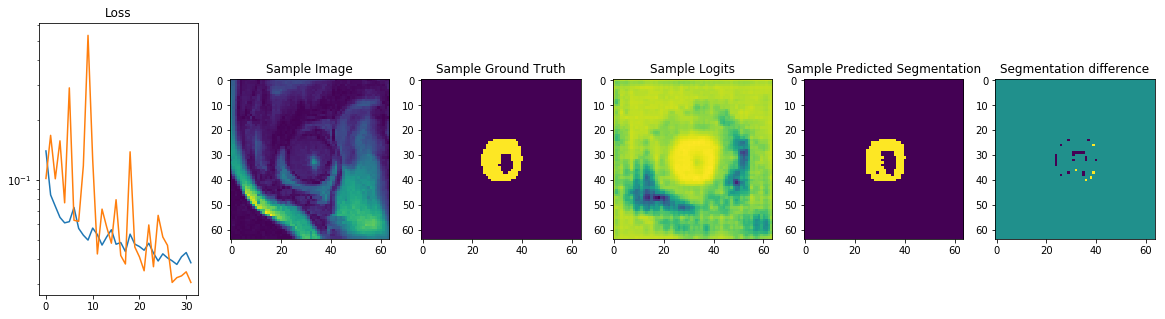

In [84]:

# result
sample = np.random.randint(0, trainTensor.shape[0]-1 )  # choose random sample to visualise segmentation the network predicted
print('Showing results from sample: %d' % sample)

pred = net.predict(trainTensor, steps=1)
predSample=np.squeeze(pred[sample,:])

fig,ax=plt.subplots(1,6,figsize=(20,5))
ax[0].set_title('Loss')
ax[0].semilogy(History.history['loss'])
ax[0].semilogy(History.history['val_loss'])
ax[1].set_title('Sample Image')
ax[1].imshow(trainImages[sample])
ax[2].set_title('Sample Ground Truth')
ax[2].imshow(trainSegs[sample])
ax[3].set_title('Sample Logits')
ax[3].imshow(predSample)
ax[4].set_title('Sample Predicted Segmentation')
ax[4].imshow(predSample>0.5)
ax[5].set_title('Segmentation difference')
ax[5].imshow((predSample>0.5)-trainSegs[sample])


## Test on unseen data

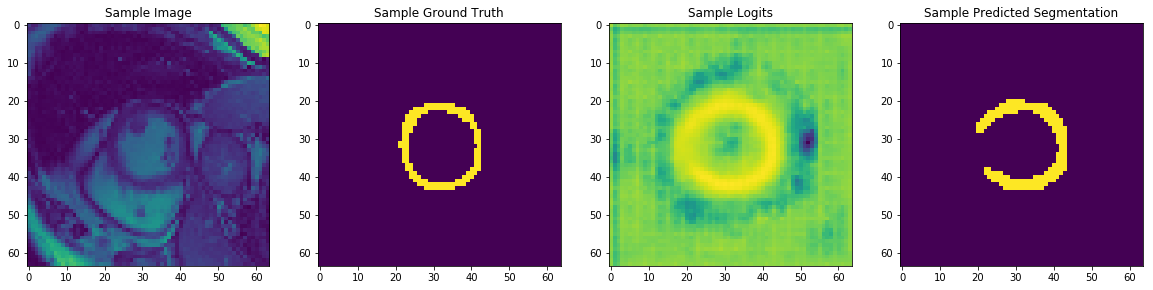

In [94]:
sample = np.random.randint(0, testImages.shape[0]-1 )  # choose random sample to visualise segmentation the network predicted for it

test_images_Tensor = tf.convert_to_tensor(testImages[:,None].astype(np.float32))
test_seg_Tensor = tf.convert_to_tensor(testSegs[:,None].astype(np.float32))

pred = net.predict(test_images_Tensor, steps = 52)

predSample=pred[sample,0,:,:]

fig,ax=plt.subplots(1,4,figsize=(20,5))
ax[0].set_title('Sample Image')
ax[0].imshow(testImages[sample])
ax[1].set_title('Sample Ground Truth')
ax[1].imshow(testSegs[sample])
ax[2].set_title('Sample Logits')
ax[2].imshow(predSample)
ax[3].set_title('Sample Predicted Segmentation')
ax[3].imshow(predSample>0.5)